<img style="float: left;" src="figures/Model1.png" width="40%"> 

# <font color='Red'>Compositional two-phase model</font>

## <font color='blue'>Introduction</font>

#### In the first case study, we cover the basic structures and procedures to run simulation with DARTS. 
#### DARTS contains a base capabilities for modeling located in [DartsModel](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/models/darts_model.py) 
    
#### This is a class that contains all the base information for creating and running the model

#### The main functions for defining the model are
* constructor of the class
* function set_reservoir()
* function set_physics()
* function set_wells()
* function set_well_controls()
* function set_initial_conditions()

#### The class DartsModel can be found in the folder <font color='red'>'darts/models'</font>.

## <font color='blue'>The objectives for the first exercise</font>
1. Be familiar with the basic procedures to run a simulation
2. Exercise on several simulation parameters, including timestep controls and mesh 

## <font color='blue'>Let's start !</font>
### Step 1. Import all necessary classes and physical properties into the workspace

In [1]:
# Import all important packages from DARTS installation
from darts.reservoirs.struct_reservoir import StructReservoir
from darts.models.darts_model import DartsModel
from darts.engines import redirect_darts_output, well_control_iface

from darts.physics.super.physics import Compositional
from darts.physics.super.property_container import PropertyContainer

from darts.physics.properties.flash import ConstantK
from darts.physics.properties.basic import ConstFunc, PhaseRelPerm
from darts.physics.properties.density import DensityBasic

redirect_darts_output('model1.log')

### Step 2. Define a model class for the simulation

In [2]:
class Model(DartsModel):
    # constructor
    def __init__(self):
        # Call base class constructor
        super().__init__()

        # Measure time spent on reading/initialization
        self.timer.node["initialization"].start()

        self.set_reservoir()
        self.set_physics()

        # base simulation parameters
        self.set_sim_params(first_ts=0.001, mult_ts=2, max_ts=1, 
                            tol_newton=1e-2, tol_linear=1e-3, it_newton=10, it_linear=50)

        self.timer.node["initialization"].stop()

    # define reservoir
    def set_reservoir(self):
        self.nx = 1000
        perm = 100
        self.reservoir = StructReservoir(self.timer, nx=self.nx, ny=1, nz=1, dx=1000/self.nx, dy=10, dz=10,
                                         permx=perm, permy=perm, permz=perm/10, poro=0.2, depth=1000)

    # define phsyics
    def set_physics(self):
        # Physical properties
        self.zero = 1e-10
        # Create property containers:
        components = ['CO2', 'H2O']
        phases = ['gas', 'wat']
        Mw = [44.01, 18.015]

        # property container is needed for flexibility to define any mixture of properties
        property_container = PropertyContainer(phases_name=phases, components_name=components,
                                               Mw=Mw, min_z=self.zero, temperature=1.)

        # properties correlations
        property_container.flash_ev = ConstantK(len(components), [40, 5e-2], self.zero)
        property_container.density_ev = dict([('gas', DensityBasic(compr=1e-3, dens0=200)),
                                              ('wat', DensityBasic(compr=1e-5, dens0=600))])
        property_container.viscosity_ev = dict([('gas', ConstFunc(0.1)),
                                                ('wat', ConstFunc(0.5))])
        property_container.rel_perm_ev = dict([('gas', PhaseRelPerm("gas")),
                                               ('wat', PhaseRelPerm("wat"))])

        # activate physics
        self.physics = Compositional(components, phases, self.timer, n_points=200, min_p=1, max_p=300,
                                     min_z=self.zero/10, max_z=1-self.zero/10)

        # can define different property regions in the model
        self.physics.add_property_region(property_container)

    # define name and well locations
    def set_wells(self):
        self.reservoir.add_well("I1")
        self.reservoir.add_perforation("I1", res_cell_idx=(1, 1, 1))

        self.reservoir.add_well("P1")
        self.reservoir.add_perforation("P1", res_cell_idx=(self.reservoir.nx, 1, 1))

    # define well controls
    def set_well_controls(self):
        zero = self.physics.axes_min[1]
        inj_composition = [1.0 - zero]
        for i, w in enumerate(self.reservoir.wells):
            if i == 0:
                self.physics.set_well_controls(wctrl=w.control, control_type=well_control_iface.BHP,
                                               is_inj=True, target=140., inj_composition=inj_composition)
            else:
                self.physics.set_well_controls(wctrl=w.control, control_type=well_control_iface.BHP,
                                               is_inj=False, target=50.)
    # define initial conditions
    def set_initial_conditions(self):
        input_distribution = {self.physics.vars[0]: 50,
                              self.physics.vars[1]: self.zero,
                              }
        return self.physics.set_initial_conditions_from_array(mesh=self.reservoir.mesh,
                                                              input_distribution=input_distribution)


### Step 3. Initialize the model and run the simulation 

In [3]:
m = Model()
m.init()
m.set_output()
m.run(600)
m.print_timers()
m.print_stat()

darts-package built on 30/01/2026 16:43:15 by smoslehi@HW1T6M3 from v1.1.3-1733-g0dbd8e12-dirty
Building connection list...
Simulation parameters:
	 eta = [1.e+20 1.e+20]
	 dt_first = 0.001
	 dt_min = 1e-15
	 dt_mult = 2
	 dt_max = 1
	 newton_tol = 0.01
	 newton_tol_wel_mult = 100.0
	 newton_tol_stationary = 0.001
	 newton_max_iter = 10
	 linear_tol = 0.001
	 linear_max_iter = 50
	 linear_type = None
	 linear_print_level = None
	 line_search = False
	 min_line_search_update = 0.0001
	 coupled_well_res_norm_method = 1
#1	T=0.001	DT=0.001	NI=2	LI=2	DT_MULT=  2	dX=[8.2609e+01 1.0000e-02]
#2	T=0.003	DT=0.002	NI=2	LI=2	DT_MULT=  2	dX=[2.28e+01 9.00e-03]
#3	T=0.007	DT=0.004	NI=2	LI=2	DT_MULT=  2	dX=[1.7474e+01 7.0000e-03]
#4	T=0.015	DT=0.008	NI=1	LI=1	DT_MULT=  2	dX=[1.553e+01 6.000e-03]
#5	T=0.031	DT=0.016	NI=1	LI=1	DT_MULT=  2	dX=[1.4638e+01 8.0000e-03]
#6	T=0.063	DT=0.032	NI=1	LI=1	DT_MULT=  2	dX=[1.4221e+01 1.2000e-02]
#7	T=0.127	DT=0.064	NI=2	LI=2	DT_MULT=  2	dX=[13.898  0.019]
#8	T=0.2

### Step 4. Plot the solution

<Figure size 640x480 with 0 Axes>

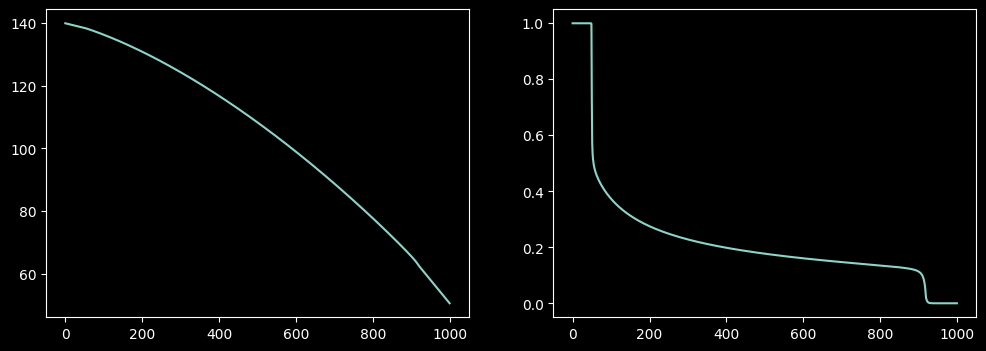

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Get numpy wrapper for final solution
X = np.array(m.physics.engine.X, copy=False)
nb = m.nx

# Prepare for plotting
fig = plt.figure()   

nc = m.physics.nc

fig, axes = plt.subplots(1, nc, figsize=(12, 4))
# Plot pressure profile
for i in range(nc):
    axes[i].plot(X[i:nc*nb:nc])


## <font color='Blue'>Tasks in this workshop (check and explain why solution behave this way):</font>

1. Change the maximum timestep from 1 to 200 days.
2. Return the timestep to 1 and change the number of gridblocks from 1000 to 100.
3. Return to 1000 gridblocks and increase permeability from 100 to 10 mDarcy.
4. Return permeability to 100 mDarcy and increase porosity from 0.2 to 0.4.